# 线性回归＋基础优化算法

线性模型可以看作是单层神经网络

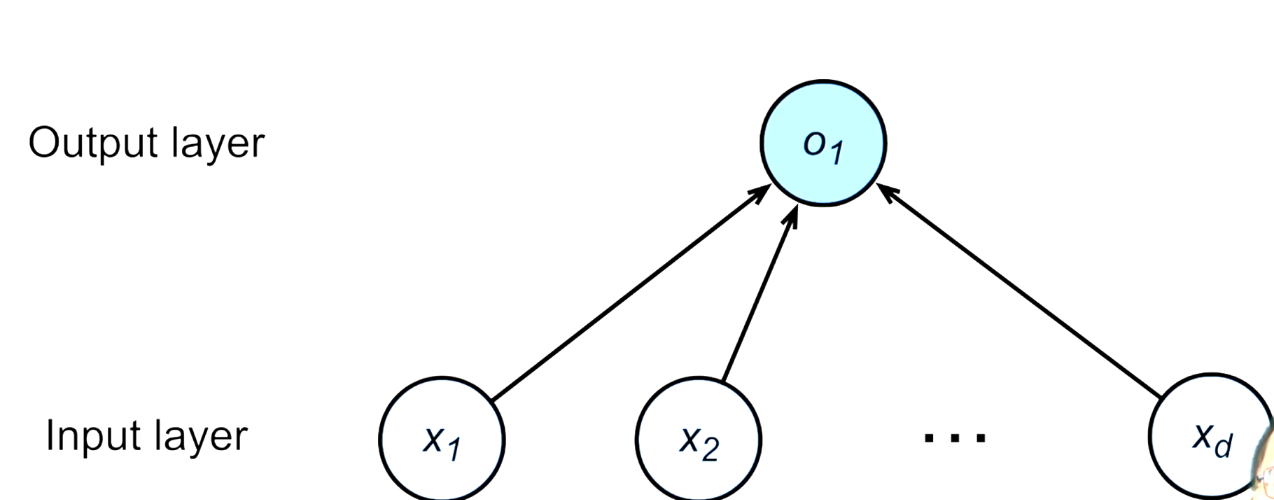

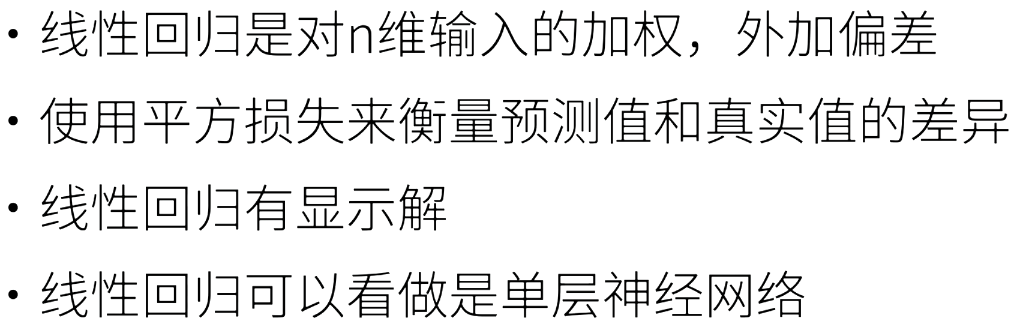

## 基础优化算法
梯度下降法

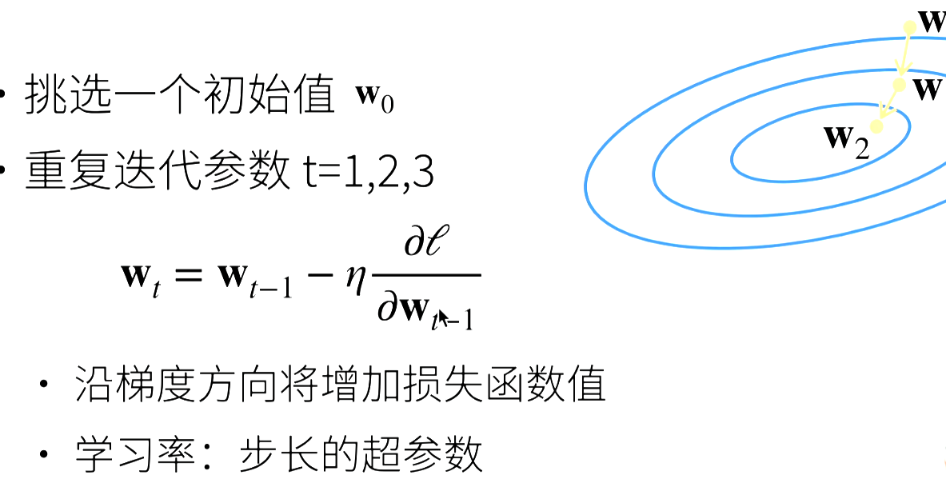

小批量随机梯度下降

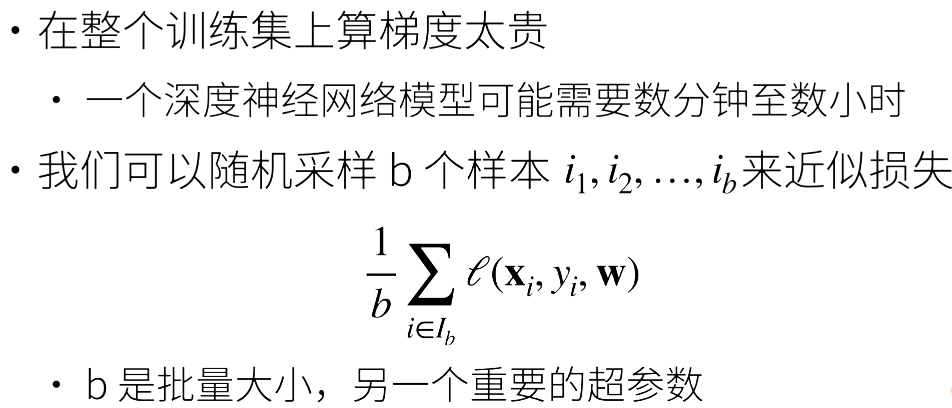

总结

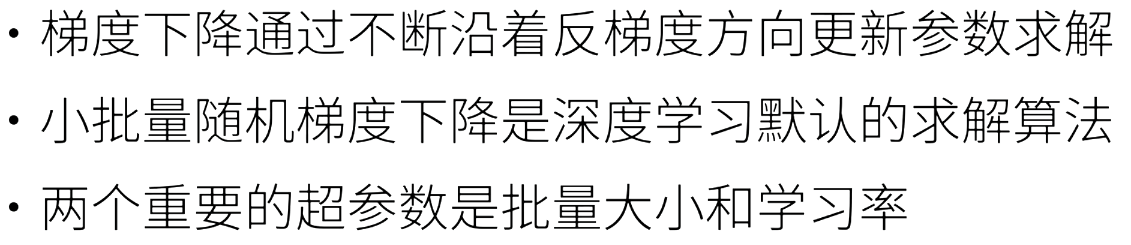

In [1]:
#导入第三方库
%matplotlib inline
import torch
import random
from d2l import torch as d2l
import numpy as np 
from torch.utils import data

## 线性回归从0开始实现

In [2]:
#根据带有噪声的线性模型构造一个人造数据集，使用线性模型参数w= [2, -3.4]^T b= 4.2和噪声项生成数据集及其标签
def synthetic_data(w, b, num_examples):
    """
    生成 y = wX + b + 噪声
    """
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    #添加噪声项，满足标准正态分布
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

features: tensor([-1.2997, -0.6507]) 
labels: tensor([3.8080])


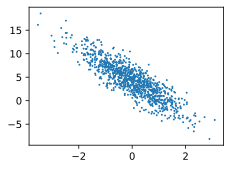

In [3]:
#features中的每一行都包含一个二维数据样本，labels中的每一行都包含一个一维标签值(一个标量)
print('features:', features[0], '\nlabels:' ,labels[0])
#绘制图片展示labels和features[0]的分布
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

In [4]:
#定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量
def data_iter(batch_size, features, labels):
    """
    接收批量大小、特征矩阵以及标签向量来生成一个大小为batch_size的小批量
    """
    #确定样本数量
    num_examples = len(labels)
    indices = list(range(num_examples))
    #随机读取的样本，没有特定顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break


tensor([[ 0.1303, -1.0410],
        [-0.6080,  0.5921],
        [-0.4225, -0.5141],
        [-1.7519, -2.7815],
        [ 0.2547,  1.0879],
        [-0.4576, -0.4482],
        [ 0.5815, -0.3154],
        [ 0.5094,  1.0594],
        [-0.2646,  0.2019],
        [ 0.3430, -0.1225]]) 
 tensor([[ 7.9933],
        [ 0.9644],
        [ 5.0994],
        [10.1501],
        [ 1.0278],
        [ 4.8050],
        [ 6.4291],
        [ 1.6080],
        [ 2.9775],
        [ 5.2861]])


In [5]:
#定义初始化模型
w = torch.normal(0, 0.01, size= (2, 1), requires_grad= True)
b = torch.zeros(1, requires_grad= True)

In [6]:
#定义模型
def linreg(X, w, b):
    """定义线性回归模型"""
    return torch.matmul(X, w) + b

#定义损失函数
def squared_loss(y_hat, y):
    """
    使用均方损失定义损失函数
    """
    #对齐y的预测值的维度
    return  (y_hat - y.reshape(y_hat.shape))**2 / 2

#定义优化函数，使用sgd
def sgd(params, lr, batch_size):
    """
    小批量随机下降法
    params:参数列表
    lr:学习率
    batch_size:批量大小
    """
    #更新时不需要梯度参与计算
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            #手动将梯度设置为0，避免梯度对下一次计算产生影响
            param.grad.zero_()

In [7]:
#训练过程
#指定超参数
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        #定义小批量损失：即期望值与目标值的差异
        l = loss(net(X, w, b), y)
        #计算loss的梯度，l的形状为(batch_size, 1)，因此需要求和后计算梯度
        l.sum().backward()
        #使用参数的梯度更新参数
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
        

epoch 1, loss 0.035098
epoch 2, loss 0.000123
epoch 3, loss 0.000046


In [8]:
#比较真实参数和通过科学训练学到的参数来评估训练的成功程度
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0003, -0.0005], grad_fn=<SubBackward0>)
b的估计误差: tensor([1.9073e-05], grad_fn=<RsubBackward1>)


## 线性回归的简洁实现

In [25]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [26]:
def load_array(data_array, batch_size, is_train= True):
    """
    使用pytorch框架中的dataset方法构建一个数据迭代器
    """
    dataset = data.TensorDataset(*data_array)
    #返回一个dataloader类
    return data.DataLoader(dataset, batch_size, shuffle= is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)
#通过next函数得到x,y的构造，iter()函数转换为python中的iter类
next(iter(data_iter))

[tensor([[ 0.4581, -1.0868],
         [ 0.5653, -1.4769],
         [-0.5057, -0.6403],
         [-0.7224, -0.7375],
         [ 0.6590,  1.3420],
         [-0.1086, -0.4742],
         [-1.5081,  1.1854],
         [-0.9936, -0.0423],
         [-0.8501, -0.0368],
         [ 1.7153, -0.5527]]),
 tensor([[ 8.8042],
         [10.3352],
         [ 5.3523],
         [ 5.2551],
         [ 0.9631],
         [ 5.6049],
         [-2.8534],
         [ 2.3537],
         [ 2.6255],
         [ 9.5188]])]

In [27]:
#使用框架预定义好的层
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))
#初始化模型参数,通过索引和方法定位权重和偏秩，分别设置为服从标准正态分布的随机数以及0
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [28]:
#计算均方误差使用MSELoss类
loss = nn.MSELoss()
#实例化SGD,传入的参数为模型参数以及学习率
trainer = torch.optim.SGD(net.parameters(), lr= 0.03)

In [29]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        #训练器的梯度设置为0
        trainer.zero_grad()
        #反向传播梯度进行参数更新
        l.backward() 
        trainer.step()

    l = loss(net(features), labels)
    print(f'epoch: {epoch + 1}, loss: {l:f}')

epoch: 1, loss: 0.000264
epoch: 2, loss: 0.000098
epoch: 3, loss: 0.000101
